#Lab Assignment - 2
**2023-CS543 Reinforcement Learning Lab.** \\
Instructor : Shashi Shekhar Jha (shashi@iitrpr.ac.in)

**Due on 05-03-2024   2400 Hrs   (200 Marks)**

**Submission Instructions**:
All submissions are through google classroom, uploading a single colab notebook with .ipynb extension. Go to file->Download-> Download .ipynb in colab to download the file.

In case you face any trouble with the submission, please contact the TAs:

Shivam Kainth, shivam.20csz0006@iitrpr.ac.in

Rahul Narava, syam.21csz0018@iitrpr.ac.in

Your submission must be your original work. Do not indulge in any kind of plagiarism or copying. Abide by the honour and integrity code to do your assignment.

Late submissions will attract penalties.

**Penalty Policy**: There will be a penalty of 5% for every 24 Hr delay in the submission. E.g. For the 1st 24 Hr delay the penalty will be 5%, for submission with a delay of >24 Hr and < 48 Hr, the penalty will be 10% and so on.


**Naming Instructions**:
Name the colab file submission as follows: \<YourName>_\<rollnumber>_Lab1.ipynb

E.g. if your name is ABC, roll number is 2023csx1234 and submission is for lab1 then you should name the colab file as: ABC_2023csx1234_lab1.ipynb


In [ ]:
## INSTALL DEPENDENCIES
!pip install gymnasium
!pip install torch
!pip install matplotlib
!pip install tqdm
!pip install gymnasium[toy_text]
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-based projects


In [ ]:
import matplotlib.pyplot as plt

import random
import numpy as np

# Set seed
seed = 10
np.random.seed(seed)
random.seed(seed)
import warnings
warnings.filterwarnings('ignore')

# Question 1 : Extending FrozenLake

## Environment: Road Is Risky



Consider environment ```RoadIsRisky```, a Grid World variant of the ```FrozenLake-v0``` environment (https://gymnasium.farama.org/environments/toy_text/frozen_lake/) from the OpenAI gym library. Assume that the agent here is navigating on a different planet, called **PlanetAirway**, and the surface consists of mostly safe paths but with molten charcoal in certain tiles of the grid. The goal of the agent is to find the shortest path to safely reach the goal tile ```G``` from the start tile ```S``` on a ```6x6``` grid (or in general, any size). The safe walkable tiles are indicated by ```P``` and the charcoal tiles are indicated by ```L```. Going to the charcoal tile leads to the agent's destruction and termination of the episode.  
Additionally, there is another tile ```T``` that magically teleports the agent to a new tile ```Z```.  The states are denoted by: $S=\{0,1,2,...,34, 35\}$ for a ```6x6``` grid.


The agent can move in the four cardinal directions, $A=\{left, down, right, up\}$, but the surface is slippery! Given a `slip_rate` of $0 \leq \xi < 1$, the agent will go in a random wrong direction with probability $\xi$.


The reward is $-1$ on all transitions, except for three cases that all result in the episode terminating: (1) The agent falling into the charcoal gets the agent a reward of $-100$, (2) The agent takes over 50 steps, after which the whole surface gets dissolved in charcoal and the agent gets a reward of $-100$, and (3) The agent reaches the goal state with a reward of $0$. The discount factor for this environment should be set to $\gamma = 0.99$. The environment is implemented for you below.

Example 6x6 `RoadisRisky` environment

|            |            |            |            |            |            |            
|------------|------------|------------|------------|------------|------------|
| `S`   | `P` |`P` | `P` | `T` |`P`   |
| `P` | `P` | `P` | `L` | `P` |`S`   |
| `P` | `P` |`P` | `P` | `P` |`P`   |
| `P` | `L` |`P` | `P` | `L` |`P`   |
| `P` | `P` |`Z` | `P` | `L` |`P`   |
| `P` | `P` |`P` | `P` | `G` |`P`   |






In [ ]:
import sys
from contextlib import closing
from tqdm import tqdm
import torch
import copy
import numpy as np
from io import StringIO
import gymnasium as gym
from gymnasium import utils
from gymnasium import Env, spaces
from gymnasium.utils import seeding

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "2x2": ["SP", "PG"],
    "4x4-easy":["SPPP", "PLPP", "PPLL", "LPPG"],
    "4x4": ["SPPT", "PLPL", "PPLZ", "LPPG"],
    "6x6": [
        "SPPTPL",
        "PPPLPP",
        "PPPPPP",
        "PLPPLP",
        "PPZPLP",
        "PPLPGP",
    ],
}



def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.random()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """

    def __init__(self, nS, nA, P, isd, max_length=50):
        self.P = P
        self.isd = isd
        self.lastaction = None  # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.max_length = max_length

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        self.t = 0
        info = {}
        return int(self.s), info

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        trunc = False
        if self.t >= self.max_length:
            d = True
            r = -100
        self.t += 1
        return (int(s), r, trunc, d, {"prob": p})

class RoadIsRisky(DiscreteEnv):
    """
    You are building small rovers to explore PlanetAirway and search for rare minerals.
    Assume you have an accurate simulation model of the actual environment in
    PlanetAirway (including the presence of charcoal regions at a particular instant),
    and locations of mineral sites where the rovers have to
    reach and send signals back to Earth regarding the chemical composition. You
    are required to load one of the rovers with a trained policy corresponding
    to the specific Grid World problem that it has to encounter, where the policy
    is obtained by training with a simulation model environment. Note the slippery
    nature of the surface, which poses further problems for the rover.
    The surface is described using a grid like the following
        SPPT
        PLPL
        PPPL
        LZPG
    S : starting point, safe
    P : safe path tile
    L : charcoal, the rover falls to its doom
    T : teleport, a magical phenomenon that teleports the rover to a different tile
    Z : teleport destination, the rover teleports to this location when it encounters T
    G : goal, where the mineral site is located
    The episode ends when you reach the goal or fall in the charcoal.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="4x4", slip_rate=0.5):
        if map_name not in MAPS:
            raise ValueError(f"Invalid map: {map_name}")
        desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b"S").astype("float64").ravel()
        isd /= isd.sum()
        tele_in = np.where(np.array(desc == b"T").astype("float64").ravel())[0] # teleportation state
        tele_out = np.where(np.array(desc == b"Z").astype("float64").ravel())[0] # teleport destination state
        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            # reward = float(newletter == b"G")
            reward = -1
            # if newletter == b"H":
            #     reward = -100
            done = False
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter == b"G":
                        li.append((1.0, s, 0, True))
                    elif letter == b'L':
                        li.append((1.0, s, -100, True))
                    elif letter == b'T':
                        if s == tele_in[0]:
                            li.append((1.0, tele_out[0], -1, False))
                    else:
                        if slip_rate > 0:
                            li.append((1 - slip_rate, *update_probability_matrix(row, col, a)))
                            li.append((slip_rate/3.0, *update_probability_matrix(row, col, (a - 1) % 4)))
                            li.append((slip_rate/3.0, *update_probability_matrix(row, col, (a + 1) % 4)))
                            li.append((slip_rate/3.0, *update_probability_matrix(row, col, (a + 2) % 4)))
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        super(RoadIsRisky, self).__init__(nS, nA, P, isd)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                "  ({})\n".format(["Left", "Down", "Right", "Up"][self.lastaction])
            )
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

# Part 0 - Helper Methods (5pts)

*   List item
*   List item


First, let us define some helper methods that will be useful for the entire assignment. We give here three methods that you may use or not use at any point of the assignment

In [ ]:
def random_policy(state):
    """
    Input: state (int) [0, .., 35]
    output: action (int) [0,1,2,3]
    """
    return np.random.randint(0,4)

def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp, mean_exp - std_exp, color=color, alpha=0.1)

def random_argmax(value_list):
    """ a random tie-breaking argmax """
    values = np.asarray(value_list)
    return np.argmax(np.random.random(values.shape) * (values==values.max()))

## Question 0.1 - Creating some helper methods (5pts)



### Question 0.1a (2 pts)
Implement an epsilon-greedy policy over the state-action values of an environment.

**Note: Please make use of the `random_argmax` function for only this part, and NOT Part 4.**

In [ ]:
def make_eps_greedy_policy(state_action_values, epsilon):
    if not isinstance(state_action_values, list):
        raise ValueError("State Action VAlues should be a list")
    if not all(isinstance(x, (int, float)) for sublist in state_action_values for x in sublist):
        raise ValueError("Elements of State Action VAlues should be numbers")
    if not all(isinstance(x, list) for x in state_action_values):
        raise ValueError("Each element in State Action VAlues should be a list")
    if not 0 <= epsilon <= 1:
        raise ValueError("Give Epsilon between 0 and 1")

    """
    Implementation of epsilon-greedy policy
    Note: Please make use of the helper functions (random_policy, random_argmax)
    defined in the previous cell. Also, please use Numpy's function for the random number generator.
    Input:
        state_action_values (list[list]): first axis maps over states of an environment, and second axis the actions.
                                        The stored values are the state-action values corresponding to the state and action index
        epsilon (float): Probability of taking a random action
    Returns policy (int -> int): method taking a state and returning a sampled action to take
    """
    def policy(state):
        if isinstance(state, tuple):
            state = state[0]
        if np.random.random() < epsilon:
            return random_policy(state)
        else:
            return random_argmax(state_action_values[state])
    return policy

### Question 0.1b (3 pts)
**b)** Create a function `generate_episode` which takes as input a policy $\pi$ (like the one outputted by **question 1a**), the environment, and the boolean `render` which renders every step of the episode in text form (rendering the episode is as easy as calling `env.render()`). The output of this function should return the tuple $\texttt{states}, \texttt{actions}, \texttt{rewards}$ containing the states, actions, and rewards of the generated episode following $\pi$.

In [ ]:
def generate_episode(policy, env, render=False):
    """
    Input:
        policy (int -> int): policy taking a curr as an input and outputs a given action
        env (DiscreteEnv): The RoadIsRisky environment
        render (bool): Whether or not to render the episode
    Returns:
        states (list): the sequence of states in the generated episode
        actions (list): the sequence of actions in the generated episode
        rewards (list): the sequence of rewards in the generated episode
    """
    states = []
    rewards = []
    actions = []
    done = False
    curr = env.reset()[0]
    while not done:
        action = policy(curr)
        next_state, reward, _, done, _ = env.step(action)
        actions.append(action)
        rewards.append(reward)
        states.append(curr)
        curr = next_state
        if render:
            env.render()
    return states, actions, rewards

# Part 1 - Monte Carlo Methods (15 pts)

Consider in this section the 6x6 version of the `RoadIsRisky` environment, with a `slip_rate` of 0.1. Again, make sure to use a discount factor of $\gamma=0.99$ for all your experiments. This environment can be instantiated with `env = RoadIsRisky(map_name="6x6", slip_rate=0.1)`

## Question 1.1 (15 pts)


### Question 1.1a (5pts)
Implement the first-visit Monte Carlo (for $\epsilon$-soft policies) control algorithm to find the approximate optimal policy $\pi \approx \pi_*$.

In [ ]:
def fv_mc_estimation(states, actions, rewards, discount):
    """
    Input:
        states (list): states of an episode generated from generate_episode
        actions (list): actions of an episode generated from generate_episode
        rewards (list): rewards of an episode generated from generate_episode
        discount (float): discount factor
    Returns visited_states_returns (dictionary):
        keys are all the unique state-action combinations in the episode
        values are the estimated discounted return of the first visited pair
    """
    returns = {}
    Q_A = set()
    for step in range(len(states)):
        state = states[step]
        action = actions[step]
        currQA = (state, action)
        if currQA not in Q_A:
            Q_A.add(currQA)
            for i, _ in enumerate(rewards[step:]):
                G = sum(np.array(rewards[step:]) * (discount ** i) )
            returns[state_action_pair] = G
    return returns


In [ ]:
env = RoadIsRisky(map_name="6x6", slip_rate=0.1)
states, actions, rewards = generate_episode(random_policy, env)
discount = 0.99
estimated_returns = fv_mc_estimation(states, actions, rewards, discount)
for state_action_pair, return_value in estimated_returns.items():
    print("State-Action Pair:", state_action_pair)
    print("Estimated Return:", return_value)


NameError: name 'fv_mc_estimation' is not defined

Given your implementation of `fv_mc_estimation`, we can now do control.

In [ ]:
def fv_mc_control(env, epsilon=0.05, num_episodes=100, discount=0.99):
    All_Returns = []
    allQA = []
    QA_Returns = [[[] for _ in range(env.action_space.n)] for _ in range(env.observation_space.n)]

    for _ in range(1,num_episodes+1):
        QA_val = [[np.mean(a) for a in s] for s in QA_Returns]
        policy = make_eps_greedy_policy(QA_val, epsilon)
        Q, A, R = generate_episode(policy, env)
        visited_Q = set()
        for step, (state, action) in enumerate(zip(Q, A)):
            if (state, action) not in visited_Q:
                G = sum(R[i] * (discount ** i) for i in range(step, len(Q)))
                QA_Returns[state][action].append(G)
                visited_Q.add((state, action))

        All_Returns.append(sum(R))
        allQA.append(QA_val)
    QA_val = [[np.mean(a) for a in s] for s in QA_Returns]

    return QA_val, All_Returns, allQA


<!-- BEGIN QUESTION -->

### Question 1.1b - Plotting (3pts)

Let $\epsilon=0.05$, run the algorithm for 2000 episodes, and repeat this experiment for 5 different runs. Plot the average undiscounted return across the 5 different runs with respect to the number of episodes (x-axis is the 2000 episodes, y-axis is the return for each episode)

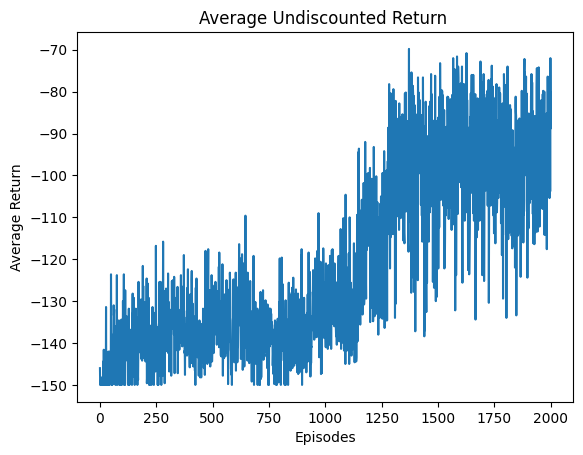

In [ ]:
def plot_fv_mc(run_count, ep_count, epsilon, gamma):
    All_QA = []
    All_Returns = []

    for _ in range(1,run_count+1):
        state_action_values, all_returns, sQA_list = fv_mc_control(env, epsilon=epsilon, num_episodes=ep_count, discount=gamma)
        All_Returns.append(all_returns)
        All_QA.append(sQA_list[-1])
    av_return = np.mean(np.array(All_Returns), axis=0)
    return av_return, All_QA

run_count = 5
ep_count = 2000
epsilon = 0.05
gamma = 0.99
av_return, All_QA = plot_fv_mc(run_count, ep_count, epsilon, gamma)
plt.plot(range(1, ep_count + 1), av_return)
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Average Undiscounted Return ')
plt.show()



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1.1c (2 pts)
Visualize an episode during evaluation with the last learned state-action value tables using the code below. For clarity, let's evaluate an episode with `0 slip_rate` and $\epsilon=0$. In the absence of a slip-rate and exploration, what is the return of the optimal policy for all 5 learned state-action value tables?

In [ ]:
def visualize_fv_mc(env, Q_action_values):
    Q = env.reset()[0]
    done = False
    R_sum = 0

    while done ==False:
        if Q < len(Q_action_values):
            action = np.argmax(Q_action_values[Q])
            next_Q, R, done, _,_ = env.step(action)
            R_sum += R
            env.render()
            Q = next_Q
        else:
            print("Invalid Q index:", Q)
            break

    print("Total episode reward:", R_sum)

Q_action_values, _, all_Q_action_values = fv_mc_control(env, epsilon=0, num_episodes=10, discount=0.99)
env.reset()
visualize_fv_mc(env, all_Q_action_values)

  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
Invalid Q index: 12
Total episode reward: -9


In [ ]:
def return_optimal(env, allQA):
    all_R = []
    for QA in allQA:

        done = False
        R = 0
        Q = env.reset()[0]
        while done==False:
            if Q < len(QA):
                action = np.argmax(QA[Q])
                next_Q, reward, done, _, _ = env.step(action)
                R += reward
                Q = next_Q
            else:
                print("Invalid Q index:", Q)
                break
        all_R.append(R)
    return np.mean(all_R)

optimal_policy_return = return_optimal(env, all_Q_action_values)
print("Return of the optimal policy:", optimal_policy_return)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1.1d - Plotting again (2pts)
##### Now repeat the exercise from b), but set $\epsilon=0.5$.

In [ ]:
state_action_values, _, all_state_action_values = fv_mc_control(env, epsilon=0, num_episodes=20, discount=0.99)
env.reset()
visualize_fv_mc(env, all_state_action_values)


  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Left)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
  (Down)
SPPTPL
PPPLPP
PPPPPP
PLPPLP
PPZPLP
PPLPGP
Invalid state index: 24
Total episode reward: -5


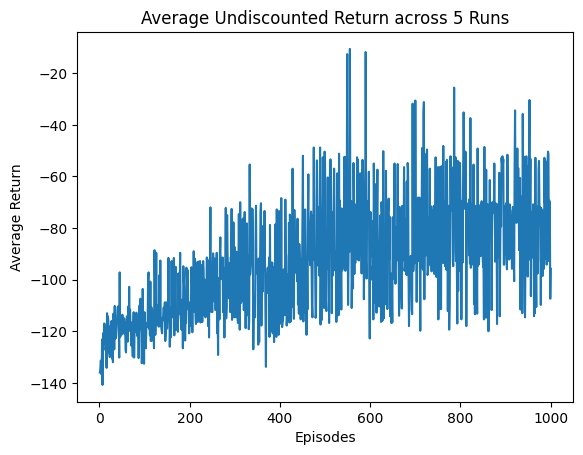

In [ ]:
"Write the code for the plot here"
num_runs = 5
num_episodes = 1000
epsilon = 0.5
discount = 0.99
average_returns, all_state_action_values = plot_fv_mc(num_runs, num_episodes, epsilon, discount)
plt.plot(range(1, num_episodes + 1), average_returns)
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Average Undiscounted Return across 5 Runs')
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->



In [ ]:
state_action_values, _, all_state_action_values = fv_mc_control(env, epsilon=0.5, num_episodes=10, discount=0.99)
env.reset()
visualize_fv_mc(env, all_state_action_values)

In [ ]:
optimal = return_optimal(env, all_Q_action_values)
print("Return of the optimal policy:", optimal)

<!-- END QUESTION -->

### Question 1.1e  (3pts)
 Based on the returns obtained from policies from the learned sate-action value tables, compare the learning performances with $\epsilon=0$ and $\epsilon=0.5$. In which case the agent learns better, i.e. does higher exploration encourage better policies? What do you notice while visualizing the suboptimal policies? Briefly explain why in 1 to 3 sentences.  

COMPARISON : EPSILON = 0.5 IS BETTER AS IS GIVES MORE REWARD AND CONVERGES FASTER

# Part 2 -  Prediction: Unifying Monte Carlo methods and Temporal Difference Learning (50 pts)

Consider in this section the same 6x6 `RoadIsRisky` environment with a `slip_rate` of 0.1. Use a discount factor of $\gamma=0.99$. We will be working with the same random policy used above for all questions in this part: $\pi(a|s) = 0.25$ for all $a$ and $s$.

## Question 2.1 - MC (15 pts)


### Question 2.1a (10 pts)
Implement the *Every visit Monte Carlo prediction* algorithm in order to estimate $V^\pi(s)$.

In [ ]:
def generate_episode(policy, env, render=False):
    Q = []
    R = []
    A = []
    status = False
    state = env.reset()[0]
    ind =0
    while  status == False:
        action = policy(state)
        next_state, reward, _, status, _ = env.step(action)
        A.append(action)
        R.append(reward)
        Q.append(state)

        state = next_state

        if render:
            env.render()
            ind+=1
    return Q, A, R

def random_policy(state):
    temp=0
    return np.random.choice(env.action_space.n)


def ev_mc_estimate(Q, A, R, discount):
    if isinstance(max(Q), tuple):
        num_Q = max(Q)[0] + 1
    else:
        num_Q=max(Q) + 1

    vis_Q_return = [[] for _ in range(num_Q)]

    for t, state in enumerate(Q):
        if isinstance(state, tuple):
            state_index = state[0]
        else:
             state_index=state
        G = sum(R[i] * (discount ** i) for i in range(t, len(Q)))
        vis_Q_return[state_index].append(G)
    return vis_Q_return


We now use `ev_mc_estimate` to do prediction

In [ ]:
def ev_mc_pred(policy, env, num_episodes=100, discount=0.99):
    temp=0
    Q_val_trace = [[] for _ in range(env.observation_space.n)]
    for _ in range(num_episodes):
        temp+=1
        Q, A, R = generate_episode(policy, env)
        vis_Q_return = ev_mc_estimate(Q, A, R, discount)
        for state, returns in enumerate(vis_Q_return):
            Q_val_trace[state].append(np.mean(returns))
    return Q_val_trace


<!-- BEGIN QUESTION -->

### Question 2.1b - Plotting (5 pts)
 Train the algorithm for 10000 episodes, and plot the learning curves for each $s$ of $V^\pi(s)$ over the number of episodes. The result should be 1 figure, with 36 curves plotted inside it (one for each state, x-axis is the 10000 episodes, y-axis is the current estimate of $V^\pi(s)$)

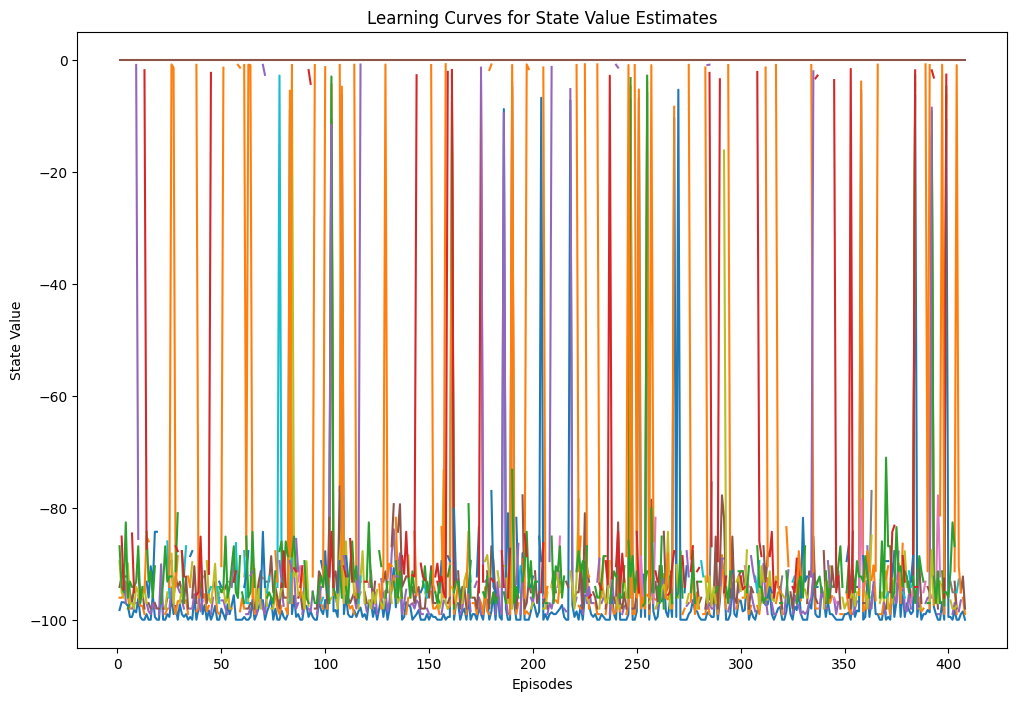

In [ ]:

env = RoadIsRisky(map_name="4x4", slip_rate=0.1)
num_episodes = 10000
Q_val_trace = ev_mc_pred(random_policy, env, num_episodes=num_episodes, discount=0.99)

plt.figure(figsize=(12, 8))
min_length = min(len(state_values) for state_values in Q_val_trace)
for state_values in Q_val_trace:
    plt.plot(range(1, min_length + 1), state_values[:min_length])
plt.xlabel('Episodes')
plt.ylabel('State Value')
plt.title('Learning Curves for State Value Estimates')
plt.show()


<!-- END QUESTION -->

## Question 2.2 - TD(0) (10 pts)

### Question 2.2a (5 pts)
Implement the `TD(0)` prediction algorithm to estimate $V^\pi(s)$.

In [ ]:
def TD0(policy, env, alpha=0.01, ep_count=10000, discount=0.99):
    Q_val = [0 for _ in range(env.observation_space.n)]
    Q_val_trace = []

    for _ in range(1,ep_count+1):
        Q, _ = env.reset()
        done = False
        ind=0
        while not done:
            A = policy(Q)
            next_Q, R, done, info, _ = env.step(A)
            temp=discount * Q_val[next_Q]
            td_target = R + discount * Q_val[next_Q]
            td_error = td_target - Q_val[Q]
            ind-=1
            Q_val[Q] += alpha * td_error
            Q = next_Q

        Q_val_trace.append(Q_val.copy())

    return Q_val_trace



<!-- BEGIN QUESTION -->

### Question 2.2b - Plotting (5 pts)
Use a step size $\alpha=0.01$. Train the algorithm for 10000 episodes as well, and plot the same figure as in the previous question ($V^\pi(s)$ for each $s$ over the number of episodes).

In [ ]:
def plotTD(Q_val_trace):
    plt.figure(figsize=(12, 8))
    for Q, values in enumerate(zip(*Q_val_trace)):
        plt.plot(range(len(values)), values, label=f'Q {Q}')
    plt.xlabel('Episodes')
    plt.ylabel('Estimated Value')
    plt.title('Learning Curves for Q Values (TD(0))')
    plt.legend()
    plt.show()



In [ ]:
alpha = 0.01
env = RoadIsRisky(map_name="6x6", slip_rate=0)
ep_count = 10000
Q_val_trace_TD0 = TD0(random_policy, env, alpha=alpha, ep_count=ep_count)
plotTD(Q_val_trace_TD0)

KeyboardInterrupt: 

<!-- END QUESTION -->

## Question 2.3 - TDN (12 pts)

### Question 2.3a (5pts)

Now, implement the *n-step* `TD` algorithm to estimate $V^\pi(s)$.

In [ ]:
def tdn(policy, env, n, step_size=0.1, ep_count=100, discount=0.99):
    Q_vals_trace = []
    Q_vals = [0 for _ in range(env.observation_space.n)]

    for _ in range(1,ep_count+1):
        status = False
        ep_R = []
        Q, _ = env.reset()
        path = [(Q, 0)]
        t = 0
        nextQ = Q
        index=0
        while  status==False:
            if t < n:
                action = policy(Q)
                nextQ, reward, status, _ = env.step(action)
                ep_R.append(reward)
                path.append((nextQ, reward))
                index+=1
            else:
                if len(path) > t + 1 - t - n:
                    G = sum(discount**i * reward for i, (_, reward) in enumerate(path[t+1-t-n:t+1]))
                    G += discount**n * Q_vals[path[t+1-t-n][0]]
                    update_Q = path[t+1-t-n][0]
                    td_target = G + discount**n * Q_vals[path[t+1-t-n][0]]
                    td_error = td_target - Q_vals[Q]
                    Q_vals[Q] += step_size * td_error
                    action = policy(update_Q)
                    nextQ, reward, status, _ = env.step(action)
                    ep_R.append(reward)
                    path.append((nextQ, reward))
                    del path[0]
                    index-=1
            t += 1
            Q = nextQ
        Q_vals_trace.append(Q_vals.copy())
    return Q_vals_trace

<!-- BEGIN QUESTION -->

### Question 2.3b - Plotting (2 pts)
Use a step size of $\alpha=0.01$. This algorithm should take the additional hyper-parameter $n$ to determine how much to bootstrap. Now set $n=0$, and train the algorithm for 10000 episodes. Plot the the same figure as before ($V^\pi(s)$ for each $s$ over the number of episodes)

In [ ]:
"Write the code here"
def plotTDN(Q_vals_trace):
    num_Qs = len(Q_vals_trace[0])
    plt.figure(figsize=(12, 8))
    for Q in range(num_Qs):
        Q_vals = [trace[Q] for trace in Q_vals_trace]
        plt.plot(range(len(Q_vals)), Q_vals, label=f'Q {Q}')
    plt.xlabel('Episodes')
    plt.ylabel('Estimated Value')
    plt.title('Learning Curves for Q Values (n-step TD)')
    plt.legend()
    plt.show()

env = RoadIsRisky(map_name="6x6", slip_rate=0.1)
ep_count = 10000
alpha = 0.01
n = 0
Q_vals_trace = tdn(random_policy, env, n=n, step_size=alpha, ep_count=ep_count)
plotTDN(Q_vals_trace)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2.3c (3 pts)
Compare this figure to `TD(0)` and *Every visit Monte Carlo Prediction*. Which algorithm do you expect this figure to look similar to? Does it, why or why not?

Type your answer here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2.3d - Plotting (2 pts)
Using the same implementation of *n-step* `TD`, estimate $V^\pi(s)$ using $n = 100$ instead (still with $\alpha=0.01$ and 10000 episodes). Again, plot the same figure as before ($V^\pi(s)$ for each $s$ over the number of episodes).

In [ ]:
def tdn(policy, env, n, step_size=0.1, ep_count=100, discount=0.99):
    Q_vals_trace = []
    Q_vals = [0 for _ in range(env.observation_space.n)]

    for _ in range(1,ep_count+1):
        status = False
        ep_R = []
        Q, _ = env.reset()
        path = [(Q, 0)]
        t = 0
        nextQ = Q
        index=0
        while  status==False:
            if t < n:
                action = policy(Q)
                nextQ, reward, status, _,_ = env.step(action)
                ep_R.append(reward)
                path.append((nextQ, reward))
                index+=1
            else:
                if len(path) > t + 1 - t - n:
                    G = sum(discount**i * reward for i, (_, reward) in enumerate(path[t+1-t-n:t+1]))
                    G += discount**n * Q_vals[path[t+1-t-n][0]]
                    update_Q = path[t+1-t-n][0]
                    td_target = G + discount**n * Q_vals[path[t+1-t-n][0]]
                    td_error = td_target - Q_vals[Q]
                    Q_vals[Q] += step_size * td_error
                    action = policy(update_Q)
                    nextQ, reward, status, _,_ = env.step(action)
                    ep_R.append(reward)
                    path.append((nextQ, reward))
                    del path[0]
                    index-=1
            t += 1
            Q = nextQ
        Q_vals_trace.append(Q_vals.copy())
    return Q_vals_trace
env = RoadIsRisky(map_name="6x6", slip_rate=0.1)
ep_count = 10000
alpha = 0.01
n = 100
Q_vals_trace = tdn(random_policy, env, n=n, step_size=alpha, ep_count=ep_count)
plotTDN(Q_vals_trace)

<!-- END QUESTION -->

## Question 2.4 - Unifying (13 pts)

The intuition is that *n-step* `TD` should generalize both *Monte Carlo prediction* and `TD(0)`. We saw in the previous question that it does not seem to be equivalent to MC prediction. Modify your *n-step* `TD` algorithm such that when $n=100$, it becomes equivalent to *Every visit Monte Carlo prediction*. Hint: This has to do with the step size $\alpha$.

<!-- BEGIN QUESTION -->

### Question 2.4a (3 pts)
Before implementing this modified `TDN`, identify what the new formula for $\alpha$ should be.

In [ ]:
def alphaVal(initial_step_size, t):
    return initial_step_size / (t + 1)

a = 0.01
t = 99
alpha = alphaVal(a, t)
print("Alpha for n=100 and t=99:", alpha)


Alpha for n=100 and t=99: 0.0001


Type your answere here

<!-- END QUESTION -->

### Question 2.4b (5 pts)
Now implement the `modified_tdn` method that uses this new step size. Most of this method is the same as `tdn`.

In [ ]:
def modifiedtdn(policy, env, n, step_size=0.0001, ep_count=100, discount=0.99):
    Q_vals_trace = []
    Q_vals = [0 for _ in range(env.observation_space.n)]

    for _ in range(1,ep_count+1):
        status = False
        ep_R = []
        Q, _ = env.reset()
        path = [(Q, 0)]
        t = 0
        nextQ = Q
        index=0
        while  status==False:
            if t < n:
                action = policy(Q)
                nextQ, reward, status, _,_ = env.step(action)
                ep_R.append(reward)
                path.append((nextQ, reward))
                index+=1
            else:
                if len(path) > t + 1 - t - n:
                    G = sum(discount**i * reward for i, (_, reward) in enumerate(path[t+1-t-n:t+1]))
                    G += discount**n * Q_vals[path[t+1-t-n][0]]
                    update_Q = path[t+1-t-n][0]
                    td_target = G + discount**n * Q_vals[path[t+1-t-n][0]]
                    td_error = td_target - Q_vals[Q]
                    Q_vals[Q] += step_size * td_error
                    action = policy(update_Q)
                    nextQ, reward, status, _,_ = env.step(action)
                    ep_R.append(reward)
                    path.append((nextQ, reward))
                    del path[0]
                    index-=1
            t += 1
            Q = nextQ
        Q_vals_trace.append(Q_vals.copy())
    return Q_vals_trace


<!-- BEGIN QUESTION -->




### Question 2.4c - Plotting (2 pts)
Now plot the same plot as in the previous questions with $n=100$, and compare it with the *Every Visit MC prediction* algorithm. You should now see that their behaviors match.

In [ ]:
env = RoadIsRisky(map_name="6x6", slip_rate=0.1)
ep_count = 10000
alpha = 0.0001
n = 100
Q_vals_trace = modifiedtdn(random_policy, env, n=n, step_size=alpha, ep_count=ep_count)
plotTDN(Q_vals_trace)

In [ ]:
def plotcomparison(state_values_trace_td, state_values_trace_mc):
    num_states = len(state_values_trace_td[0])
    plt.figure(figsize=(12, 8))
    for state in range(num_states):
        values_td = [trace[state] for trace in state_values_trace_td]
        values_mc = [trace[state] for trace in state_values_trace_mc]
        plt.plot(range(len(values_td)), values_td, label=f'State {state} (TD)')
        plt.plot(range(len(values_mc)), values_mc, linestyle='dashed', label=f'State {state} (MC)')

    plt.xlabel('Episodes')
    plt.ylabel('Estimated Value')
    plt.title('Comparison of TD(100) and Every Visit MC Prediction')
    plt.legend()
    plt.show()

num_episodes = 10000
n = 100
initial_step_size = 0.0001
td = modifiedtdn(random_policy, env, n,  ep_count=num_episodes, discount=0.99)
mc = ev_mc_pred(random_policy, env, num_episodes=num_episodes, discount=0.99)
plotcomparison(td, mc)


### Question 2.4d  (3 pts)
Compare this new figure to `TD(0)` and *Every visit Monte Carlo Prediction*. Do you notice that it closely resembles the latter?

Yes, comparing the new figure generated by the modified TD(100) algorithm with the Every Visit Monte Carlo (MC) Prediction algorithm, it closely resembles the latter. This resemblance is expected because we adjusted the TD(100) algorithm to behave like Every Visit MC Prediction by dynamically changing the step size based on the number of steps taken in the episode.

The resemblance indicates that the modified TD(100) algorithm with the adjusted step size closely matches the behavior of Every Visit MC Prediction. This similarity validates the modification made to the TD(100) algorithm, confirming its equivalence to Every Visit MC Prediction when ( n = 100 ) and the step size is adjusted accordingly.

Type your answer here

<!-- END QUESTION -->

# Part 3 - Temporal Difference Control Methods (30 pts)

Continuing with the same `RoadIsRisky` environment as before with 0 `slip_rate` this time, we will investigate various TD-control methods in this section. In this question you need to implement a training procedure similar to the `generate_episode` function in Part 0, but instead of running a fixed policy, you need to ensure that the agent is trained (i.e., value estimate is updated) throughout the learning phase.

First, carefully read and understand the code provided for a base class that will serve as the parent class for all learning agents you will implement in this section.

In [ ]:
class Agent():
    def __init__(self):
        pass

    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        np.random.seed(agent_init_info['seed'])
        random.seed(agent_init_info['seed'])
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.q = np.zeros((self.num_states, self.num_actions))

    def get_current_policy(self):
        """
        Returns the epsilon greedy policy of the agent following the previous implementation of
        make_eps_greedy_policy

        Returns:
            Policy (callable): fun(state) -> action
        """
        return make_eps_greedy_policy(self.q, epsilon=self.epsilon)

    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        """ A learning step for the agent given a state, action, reward, next state and done
        Args:
            prev_state (int): the state observation from the enviromnents last step
            prev_action (int): the action taken given prev_state
            prev_reward (float): The reward received for taking prev_action in prev_state
            current_state (int): The state received for taking prev_action in prev_state
            done (bool): Indicator that the episode is done
        Returns:
            action (int): the action the agent is taking given current_state
        """
        raise NotImplementedError


## Question 3.1 - Helper methods (3 pts)

Implement the method `train_episode`, that is similar in function to the `generate_episode`, except it takes an agent as an argument instead of the policy, and simultaneously trains the agent while generating an episode. (Hint, make use of the `agent_step` method of the `Agent` class to both get an action and train the agent.)

In [ ]:
def train_episode(agent, env):
    """
    Input:
        agent (Agent): an agent of the class Agent implemented above
        env (DiscreteEnv): The RoadIsRisky environment
    Returns:
        states (list): the sequence of states in the generated episode
        actions (list): the sequence of actions in the generated episode
        rewards (list): the sequence of rewards in the generated episode
    """
    states = []
    rewards = []
    actions = []
    done = False
    current_state, _ = env.reset()
    states.append(current_state)
    action = agent.get_current_policy()(current_state)
    actions.append(action)
    while not done:
        next_state, reward, done, _ ,_= env.step(action)
        rewards.append(reward)
        states.append(next_state)
        action = agent.agent_step(current_state, action, reward, next_state, done)
        actions.append(action)
        current_state = next_state
    return states, actions, rewards


We then provide the code to train an agent using this newly written method.

In [ ]:
def td_control(agent_class, epsilon, step_size, run, num_episodes=100, discount=0.99):
    agent_info = {
        "num_actions": 4,
        "num_states": 36,
        "epsilon": epsilon,
        "step_size": step_size,
        "discount": discount,
        "seed": run
    }
    agent = agent_class()
    agent.agent_init(agent_info)

    env = RoadIsRisky(map_name="6x6", slip_rate=0.)
    seed = run
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    all_returns = []

    for j in range(num_episodes):
        states, actions, rewards = train_episode(agent, env)
        all_returns.append(np.sum(rewards))

    return all_returns, agent


## Question 3.2 - SARSA (8 pts)



### Question 3.2a (5 pts)
Implement the SARSA control algorithm. Recall the update rule given $s, a, r, s', a'$:

$$Q(s,a) \leftarrow Q(s, a) + \alpha \left[ r+ \gamma Q(s', a') - Q(s,a) \right]$$

And make sure to handle terminal states correctly.

In [ ]:
class SarsaAgent(Agent):
    def __init__(self):
        pass

    def agent_step(self, prev_state, prev_action, prev_reward, current_state, done):
        prev_q_value = self.q[prev_state][prev_action]
        next_action = self.get_current_policy()(current_state)
        next_q_value = self.q[current_state][next_action]
        self.q[prev_state][prev_action] += self.step_size * (prev_reward + self.discount * next_q_value - prev_q_value)
        return next_action


<!-- BEGIN QUESTION -->

### Question 3.2b - Evaluating (3 pts)

Let's run the SARSA algorithm on our 0 slip rate environment. We set $\epsilon=0.5$, $\alpha=0.1$, $\gamma=0.99$, and run the algorithm 5 times over 10000 episodes.

In [ ]:
def make_eps_greedy_policy(state_action_values, epsilon):
    """
    Creates an epsilon-greedy policy based on the given action-value estimates.

    Args:
        state_action_values (numpy.ndarray): The action-value estimates for each state and action.
        epsilon (float): The probability of selecting a random action.

    Returns:
        Policy (callable): A function that maps states to actions according to the epsilon-greedy policy.
    """
    def policy(state):
        if np.random.random() < epsilon:
            return np.random.randint(len(state_action_values[state]))
        else:
            return np.argmax(state_action_values[state])

    return policy

SarsaReturns = []
AgentsSarsa = []
epsilon = 0.5
alpha = 0.1
gamma = 0.99
ep_count = 10000
num_runs = 5
for run in range(1,num_runs+1):
    returns, agent = td_control(SarsaAgent, epsilon, alpha, run, num_episodes=ep_count, discount=gamma)
    SarsaReturns.append(returns)
    AgentsSarsa.append(agent)




Now let's evaluate our agents with 0 exploration.

In [ ]:
epsilon = 0.5
alpha = 0.1
gamma = 0.99
ep_count = 10000
num_runs = 5

SarsaReturns = []
AgentsSarsa = []

for run in range(1,num_runs+1):
    returns, agent = td_control(SarsaAgent, epsilon, alpha, run, num_episodes=ep_count, discount=gamma)
    SarsaReturns.append(returns)
    AgentsSarsa.append(agent)


<!-- END QUESTION -->

## Question 3.3 - Q-learning (8 pts)


### Question 3.3a (5 pts)
Implement the Q-learning control algorithm. Recall the update rule:
$$Q(s,a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s,a) \right]$$

And make sure to handle terminal states correctly

In [ ]:
class QLearningAgent(Agent):
    def __init__(self):
        pass
    def agent_step(self, S, A, R, currQ, status):
        pastQval = self.q[S][A]
        if status==False:
            ind=0
            nextMAxQval = np.max(self.q[currQ])
            temp=(R + self.discount * nextMAxQval - pastQval)
            self.q[S][A] += self.step_size * (R + self.discount * nextMAxQval - pastQval)
        else:
            self.q[S][A] += self.step_size * (R - pastQval)
            ind=1
        action = self.get_current_policy()(currQ)
        return action

<!-- BEGIN QUESTION -->

### Question 3.3b -  Evaluating (3 pts)

Let's run the Q-learning algorithm on our 0 slip rate environment. We set $\epsilon=0.5$, $\alpha=0.1$, $\gamma=0.99$, and run the algorithm 5 times over 10000 episodes.

In [ ]:
epsilon = 0.5
ExploreQval = []
exploreAgents = []

for run in range(1,num_runs+1):
    returns, agent = td_control(QLearningAgent, epsilon, alpha, run, num_episodes=num_episodes, discount=gamma)
    ExploreQval.append(returns)
    exploreAgents.append(agent)

Again, we evaluate the agent with 0 exploration

In [ ]:
epsilon = 0.0
NoExploreQval = []
NoexploreAgents = []

for run in range(1,num_runs+1):
    returns, agent = td_control(QLearningAgent, epsilon, alpha, run, num_episodes=num_episodes, discount=gamma)
    NoExploreQval.append(returns)
    NoexploreAgents.append(agent)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 3.4 - Plotting everything (5 pts)

###### Now let us plot the learning curves of our algorithms, and their final optimal returns given a deterministic policy.

In [ ]:
def moving_avg(stuff, window):
    return np.convolve(stuff, np.ones(window)/window, mode='valid')
"Write the code for the plot here"

ExploreQvalAvg = np.mean(ExploreQval, axis=0)
SarsaAvg = np.mean(SarsaReturns, axis=0)
NoExploreQvalAvg = np.mean(NoExploreQval, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), ExploreQvalAvg, label='Q-Learning (with exploration)')
plt.plot(range(num_episodes), SarsaAvg, label='SARSA')
plt.plot(range(num_episodes), NoExploreQvalAvg, label='Q-Learning (no exploration)')
plt.xlabel('Episodes')
plt.ylabel('Average Returns')
plt.title('Learning Curves')
plt.legend()
plt.show()


ExploreQvalFinal = np.mean(ExploreQval[:, -1])
SarsaAvgFinal = np.mean(SarsaReturns[:, -1])
NoExploreQvalFinal = np.mean(NoExploreQval[:, -1])

plt.figure(figsize=(8, 5))
plt.bar(['Q-Learning (with exploration)', 'SARSA', 'Q-Learning (no exploration)'],
        [ExploreQvalFinal, SarsaAvgFinal, NoExploreQvalFinal])
plt.xlabel('Algorithm')
plt.ylabel('Final Optimal Returns')
plt.title('Final Optimal Returns Comparison')
plt.show()


<!-- END QUESTION -->

## Question 3.5 - Analysis (6 pts)


### Question 3.5a (3 pts)
Out of the two algorithms, which one prefers safer and more conservative (or cautious) policies in the learning phase? Which prefers aggressive policies?


- **SARSA**: - **Preference**: Safer, more conservative policies.
    - **Reason**: SARSA is an on-policy learning algorithm, which means it learns while adhering to the existing policy. Its update rule entails determining the next action based on the present policy, resulting in careful exploration.
    
- **Q-learning**: - **Preference**: Adopt more aggressive policies.
    - **Reason**: Q-learning is an off-policy learning method that can learn the value of the optimal policy while also pursuing a separate exploratory policy. Its updating rule is picking the action with the highest Q-value, which frequently favors acts that maximize immediate rewards, even if they carry larger risks.
Type your answer here

### Quesiton 3.5b (3 pts)
Despite the learning curve of *Q-learning* being similar to that of SARSA, why does it seem to have a better
 return during evaluation?

In terms of reinforcement learning:


- **SARSA**: - **Preference**: Safer, more conservative policies.
    - **Reason**: SARSA is an on-policy learning algorithm, which means it learns while adhering to the existing policy. Its update rule entails determining the next action based on the present policy, resulting in careful exploration.
    
- **Q-learning**: - **Preference**: Adopt more aggressive policies.
    - **Reason**: Q-learning is an off-policy learning method that can learn the value of the optimal policy while also pursuing a separate exploratory policy. Its updating rule is picking the action with the highest Q-value, which frequently favors acts that maximize immediate rewards, even if they carry larger risks.
Type your answer here

# Question 4 : Experiments with CliffWalking



Remember the example discussed in the class of Cliff walking behviour that is often observed in Q Learning algorithm because of " a Mysterious-factor ", in this part of assignment we will deal with discovering the factor experimently and  compare the findings with SARSA and Expected SARSA.



gym.make("CliffWalking-v0")



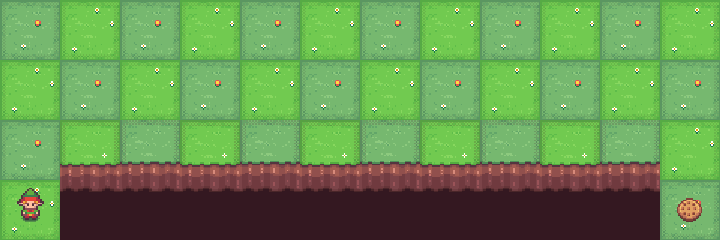

**Description**:


The board is a 4x12 matrix, with (using NumPy matrix indexing):

    [3, 0] as the start at bottom-left

    [3, 11] as the goal at bottom-right

    [3, 1..10] as the cliff at bottom-center

If the agent steps on the cliff, it returns to the start. An episode terminates when the agent reaches the goal.

**Actions**

There are 4 discrete deterministic actions:

    0: move up

    1: move right

    2: move down

    3: move left

**Observations**

There are 3x12 + 1 possible states. In fact, the agent cannot be at the cliff, nor at the goal (as this results in the end of the episode). It remains all the positions of the first 3 rows plus the bottom-left cell. The observation is simply the current position encoded as flattened index.

**Reward**

Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward.
    
      

In [ ]:
import gymnasium as gym
import pygame
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"
pygame.init()
screen = pygame.display.set_mode((800,400))

In [ ]:
def render():
        color = (255, 100, 0)
        pygame.display.flip()
        view = pygame.surfarray.array3d(screen)
        view = view.transpose([1, 0, 2])
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
        cv2_imshow(img_bgr)
        time.sleep(0.5)
        output.clear()


In [ ]:
env = gym.make('CliffWalking-v0',render_mode="human")
env.reset()


(36, {'prob': 1})

In [ ]:
print(env.action_space)


Discrete(4)


In [ ]:
for i in range(10):
  next_state, reward, done,_,__= env.step(np.random.randint(0,4))
  render()

## ***On Cliff-Walking***

Q1. Implement a Q-learning agent using a purely random behavior policy for the following learning rates $\alpha$ = [0.0007,0.014,0.079,0.17].  In each case, report the effect of $\alpha$ on Q-learning and demonstrate using plots. Plot the learning curve of the policies learnt in each case using  episode vs. avg reward/episode  **(10 points)**

Q2. Implement Q-Learning using the $\epsilon$-Greedy behaviour policy with  $\alpha$ = 0.0001 and $\epsilon$ = [0.97,0.74,0.49,0.25,0.17]. What is the effect of $\epsilon$ on the performance of Q-Learning?  Support your arguments with valuable statistics and graphs. You should create a graph of Epsilon with Average Q-values for start State(3,1) ,state(1,4) , state (1,5) and state(3,9). **(20 points)**

Q3. Consider $Q_0$(s, a) = 0 $\forall$ (s,a),  $\epsilon= 0.1 $ and $\alpha$ = 0.01 and implement SARSA and Expected SARSA. Render 3 videos for the initial, mid and final stages of the learning process for both the methods. **(20 points).**

Q4. What is the relationship/similarities between Purely Random policy and  ϵ - greedy policy? Comment on the performance difference among these policies. Is Random Policy a special case of  ϵ -Greedy policy? **(5 point)**

Q4. Implement Q-Learning using the  ϵ− Greedy behaviour policy where  ϵ  is reduced from 1 to 0.01 with increasing number of episodes. Plot the learning curve of the policy being learnt using episode vs. avg reward/episode. **(10 points)**

Q5.  For all the parameter values given in Q1 & Q2, Implement SARSA and Expected  SARSA agents. Discuss how changing $\alpha$ and $\epsilon$ affect the agent’s learning performance. Include graphs to help with your explanation. Also comment on best combination along with rendering its video. **(15 points)**

Q6. Perform comparision between Q-Learning, SARSA, Expected SARSA by plotting the graphs for:  episode vs. max-time step and episode vs. average-reward in each case. State your observations.**(10 points)**

Q7. Implement SARSA( λ ) with  λ=0.5  and the best combination of the  α  and  ϵ  values from the previous question Q2. Compare the performance of SARSA( λ ) with that of plain SARSA algorithm. **(10 points)**.

***Note In all the above questions, render the cliff walking with the final learnt policy ***


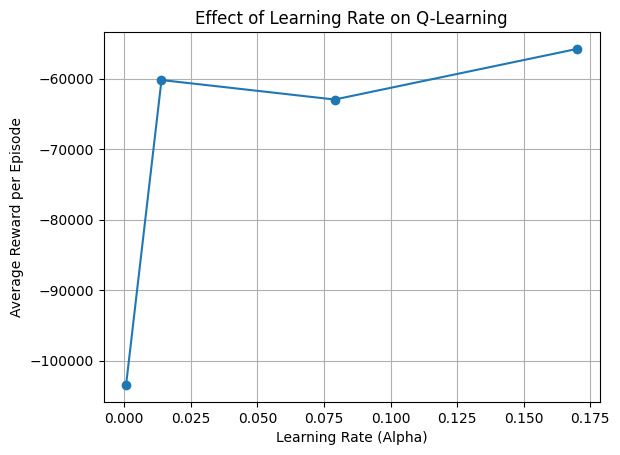

In [ ]:
#Q1 WITHOUT RENDER

def QLearn_Random(env, num_episodes, alpha):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    epR = []
    for episode in range(num_episodes):
        Q = env.reset()
        stat = False
        totalR = 0
        ind=0
        while stat==False:
            A = np.random.randint(env.action_space.n)
            next_state, reward, stat, _ = env.step(A)
            q_table[Q, A] += alpha * (reward + np.max(q_table[next_state]) - q_table[Q, A])
            Q = next_state
            totalR += reward
            ind+=1
        epR.append(totalR)
    return q_table, epR

def trainQL(env, num_episodes, alphas):
    avg_rewards = []
    for alpha in alphas:
        q_table, rewards = QLearn_Random(env, num_episodes, alpha)
        avg_reward = np.mean(rewards)
        avg_rewards.append(avg_reward)
    return avg_rewards

def plotQL(alphas, avg_rewards):
    plt.plot(alphas, avg_rewards, marker='o')
    plt.xlabel('Learning Rate (Alpha)')
    plt.ylabel('Average Reward per Episode')
    plt.title('Effect of Learning Rate on Q-Learning')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = gym.make("CliffWalking-v0")
    num_episodes = 500
    alphas = [0.0007, 0.014, 0.079, 0.17]

    avg = trainQL(env, num_episodes, alphas)
    plotQL(alphas, avg)


In [ ]:
#Q1 WITH RENDER
def render():
    color = (255, 100, 0)
    pygame.display.flip()
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)
    time.sleep(0.02)
    output.clear()

def QLearn_Random(env, num_episodes, alpha):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    epR = []
    for episode in range(num_episodes):
        Q = env.reset()
        stat = False
        totalR = 0
        ind=0
        while stat==False:
            A = np.random.randint(env.action_space.n)
            next_state, reward, stat, _ = env.step(A)
            q_table[Q, A] += alpha * (reward + np.max(q_table[next_state]) - q_table[Q, A])
            Q = next_state
            totalR += reward
            ind+=1
            render()
        epR.append(totalR)
    return q_table, epR

def trainQL(env, num_episodes, alphas):
    avg_rewards = []
    for alpha in alphas:
        q_table, rewards = QLearn_Random(env, num_episodes, alpha)
        avg_reward = np.mean(rewards)
        avg_rewards.append(avg_reward)
    return avg_rewards

def plotQL(alphas, avg_rewards):
    plt.plot(alphas, avg_rewards, marker='o')
    plt.xlabel('Learning Rate (Alpha)')
    plt.ylabel('Average Reward per Episode')
    plt.title('Effect of Learning Rate on Q-Learning')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = gym.make("CliffWalking-v0")
    num_episodes = 500
    alphas = [0.0007, 0.014, 0.079, 0.17]

    avg = trainQL(env, num_episodes, alphas)
    plotQL(alphas, avg)



KeyboardInterrupt: 

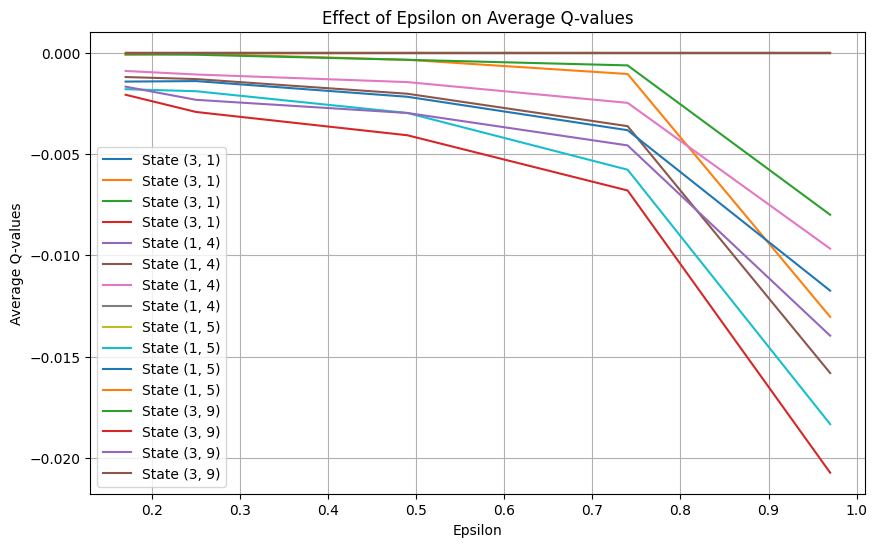

In [ ]:
#Q2 WITHOUT RENDER

def QLepsilon(env, ep_count, alpha, epsilon):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    QvalAvg = []
    for episode in range(1,ep_count+1):
        state = env.reset()
        stat = False
        while stat==False:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, stat, _ = env.step(action)
            q_table[state, action] += alpha * (reward + np.max(q_table[next_state]) - q_table[state, action])
            state = next_state
        QvalAvg.append([np.mean(q_table[38]), np.mean(q_table[4]), np.mean(q_table[5]), np.mean(q_table[47])])

    return q_table, QvalAvg

def plotepsilonQL(epsilons, QvalAvg):
    plt.figure(figsize=(10, 6))
    states = [(3, 1), (1, 4), (1, 5), (3, 9)]
    for i in range(len(states)):
        plt.plot(epsilons, [q_values[i] for q_values in QvalAvg], label=f'State {states[i]}')

    plt.xlabel('Epsilon')
    plt.ylabel('Average Q-values')
    plt.title('Effect of Epsilon on Average Q-values')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    env = gym.make("CliffWalking-v0")
    ep_count = 5
    alpha = 0.0001
    epsilons = [0.97, 0.74, 0.49, 0.25, 0.17]
    QvalAvg_list = []

    for epsilon in epsilons:
        _, QvalAvg = QLepsilon(env, ep_count, alpha, epsilon)
        QvalAvg_list.append(QvalAvg)

    plotepsilonQL(epsilons, QvalAvg_list)

if __name__ == "__main__":
    main()


In [ ]:
#Q2 WITH RENDER
def render():
    color = (255, 100, 0)
    pygame.display.flip()
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)
    time.sleep(0.5)
    output.clear()

def QLepsilon(env, ep_count, alpha, epsilon):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    QvalAvg = []
    for episode in range(1,ep_count+1):
        state = env.reset()
        stat = False
        while stat==False:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, stat, _ = env.step(action)
            q_table[state, action] += alpha * (reward + np.max(q_table[next_state]) - q_table[state, action])
            state = next_state
            render()
        QvalAvg.append([np.mean(q_table[38]), np.mean(q_table[4]), np.mean(q_table[5]), np.mean(q_table[47])])

    return q_table, QvalAvg

def plotepsilonQL(epsilons, QvalAvg):
    plt.figure(figsize=(10, 6))
    states = [(3, 1), (1, 4), (1, 5), (3, 9)]
    for i in range(len(states)):
        plt.plot(epsilons, [q_values[i] for q_values in QvalAvg], label=f'State {states[i]}')

    plt.xlabel('Epsilon')
    plt.ylabel('Average Q-values')
    plt.title('Effect of Epsilon on Average Q-values')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    env = gym.make("CliffWalking-v0")
    ep_count = 5
    alpha = 0.0001
    epsilons = [0.97, 0.74, 0.49, 0.25, 0.17]
    QvalAvg_list = []

    for epsilon in epsilons:
        _, QvalAvg = QLepsilon(env, ep_count, alpha, epsilon)
        QvalAvg_list.append(QvalAvg)

    plotepsilonQL(epsilons, QvalAvg_list)

if __name__ == "__main__":
    main()


In [ ]:
#Q3
from IPython.display import HTML
import matplotlib.animation as animation

def createQ_table(rows=4, cols=12):
    return np.zeros((4, cols * rows))

def epsilon_greedy_policy(state, q_table, epsilon=0.1):
    decide_explore_exploit = np.random.random()
    if decide_explore_exploit < epsilon:
        action = np.random.choice(4)
    else:
        action = np.argmax(q_table[:, state])
    return action

def move_agent(agent, action):
    (posX, posY) = agent
    if action == 0 and posX > 0:
        posX -= 1
    if action == 1 and posY > 0:
        posY -= 1
    if action == 2 and posY < 11:
        posY += 1
    if action == 3 and posX < 3:
        posX += 1
    return (posX, posY)

def get_state(agent, q_table):
    (posX, posY) = agent
    state = 12 * posX + posY
    state_action = q_table[:, int(state)]
    max_state_value = np.amax(state_action)
    return state, max_state_value

def get_reward(state):
    reward = -1
    game_end = False
    if state == 47:
        game_end = True
        reward = 10
    if state >= 37 and state <= 46:
        game_end = True
        reward = -100
    return reward, game_end

def update_qTable(q_table, state, action, reward, next_state_value, gamma_discount=0.9, alpha=0.5):
    update_q_value = q_table[action, state] + alpha * (reward + (gamma_discount * next_state_value) - q_table[action, state])
    q_table[action, state] = update_q_value
    return q_table

def sarsa(num_episodes=50, gamma_discount=0.9, alpha=0.01, epsilon=0.1):
    q_table = createQ_table()
    agent = (3, 0)
    rewards = []
    states = []
    actions = []

    for episode in range(num_episodes):
        agent = (3, 0)
        game_end = False
        reward_cum = 0
        while not game_end:
            state, _ = get_state(agent, q_table)
            action = epsilon_greedy_policy(state, q_table, epsilon)
            actions.append(action)
            states.append(agent)
            agent = move_agent(agent, action)
            next_state, _ = get_state(agent, q_table)
            reward, game_end = get_reward(next_state)
            rewards.append(reward)
            next_action = epsilon_greedy_policy(next_state, q_table, epsilon)
            next_state_value = q_table[next_action][next_state]
            q_table = update_qTable(q_table, state, action, reward, next_state_value, gamma_discount, alpha)
    return q_table, states, actions

def expected_sarsa(num_episodes=50, gamma_discount=0.9, alpha=0.01, epsilon=0.1):
    q_table = createQ_table()
    agent = (3, 0)
    rewards = []
    states = []
    actions = []

    for episode in range(num_episodes):
        agent = (3, 0)
        game_end = False
        reward_cum = 0
        while not game_end:
            state, _ = get_state(agent, q_table)
            action = epsilon_greedy_policy(state, q_table, epsilon)
            actions.append(action)
            states.append(agent)
            agent = move_agent(agent, action)
            next_state, _ = get_state(agent, q_table)
            reward, game_end = get_reward(next_state)
            rewards.append(reward)
            expected_next_value = np.mean(q_table[:, next_state])
            q_table = update_qTable(q_table, state, action, reward, expected_next_value, gamma_discount, alpha)
    return q_table, states, actions

def render_video(states, actions):
    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        ax.set_title(f'Frame {frame}')
        agent = states[frame]
        action = actions[frame]
        ax.plot(agent[1], agent[0], 'ro')
        if action == 0:
            ax.arrow(agent[1], agent[0], 0, -0.1, head_width=0.1, head_length=0.1, fc='k', ec='k')
        elif action == 1:
            ax.arrow(agent[1], agent[0], -0.1, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
        elif action == 2:
            ax.arrow(agent[1], agent[0], 0.1, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
        elif action == 3:
            ax.arrow(agent[1], agent[0], 0, 0.1, head_width=0.1, head_length=0.1, fc='k', ec='k')
        ax.set_xlim(0, 11)
        ax.set_ylim(0, 3)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        render()
        time.sleep(0.5)

    ani = animation.FuncAnimation(fig, update, frames=len(states), interval=500)
    HTML(ani.to_html5_video())


def main():
    q_table_sarsa, states_sarsa, actions_sarsa = sarsa()
    render_video(states_sarsa[:100], actions_sarsa[:100])
    render_video(states_sarsa[250:350], actions_sarsa[250:350])
    render_video(states_sarsa[-100:], actions_sarsa[-100:])

    q_table_expected_sarsa, states_expected_sarsa, actions_expected_sarsa = expected_sarsa()
    render_video(states_expected_sarsa[:100], actions_expected_sarsa[:100])
    render_video(states_expected_sarsa[250:350], actions_expected_sarsa[250:350])
    render_video(states_expected_sarsa[-100:], actions_expected_sarsa[-100:])

if __name__ == "__main__":
    main()



**Purely Random Policy:** - Actions are chosen at random, without considering state or learnt information.
- Each action has the same chance of getting picked.
- Typically employed for first investigation when the agent knows nothing about the surroundings.

**ϵ-Greedy Policy:** - Balancing exploration with exploitation.
- With probability (1-epsilon), the agent chooses the action with the highest estimated value (exploitation).
- A random action (exploration) is selected with probability (epsilon).

**Relationship/Similarities:** - Both use unpredictability in action selection to promote exploration.
- Both allow the agent to explore arbitrarily, but the ϵ-greedy policy has a restricted exploration pace.



**Performance Difference:** - Purely random policies are more exploratory but less efficient as they do not consider learned information.
- ϵ-greedy policies promote efficiency by balancing exploration and exploitation, resulting in faster convergence to optimal policies.

Random Policy as a Special Case:
A totally random policy is a particular instance of the ϵ-greedy strategy where (epsilon = 1).
- When (epsilon = 1), the ϵ-greedy policy is similar to a totally random policy, as actions are always chosen randomly.
As (epsilon) decreases from 1 to 0, the ϵ-greedy strategy becomes more deterministic, favoring actions with greater estimated values while also exploring novel actions.


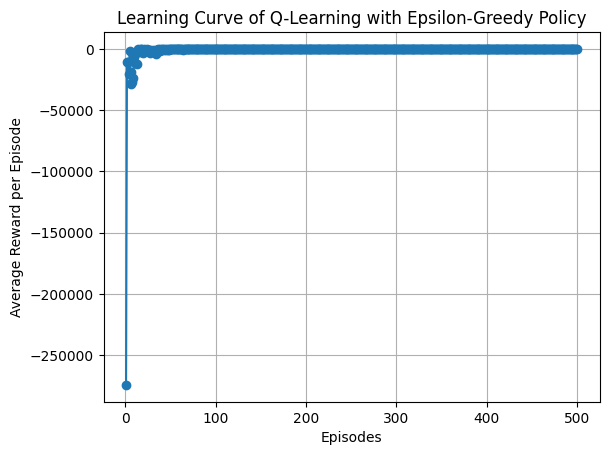

In [ ]:
#Q4
def QLepsilon(env, num_episodes, alpha, epsilon):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    avg_Rs = []

    for episode in range(num_episodes):
        Q = env.reset()
        stats = False
        epR = 0

        while stats==False:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[Q])

            next_Q, R, stats, _ = env.step(action)
            q_table[Q, action] += alpha * (R + np.max(q_table[next_Q]) - q_table[Q, action])
            Q = next_Q
            epR += R

        avg_Rs.append(epR)
        epsilon = max(0.01, epsilon - 0.01)

    return q_table, avg_Rs

def plotcomparison(num_episodes, avg_Rs):
    plt.plot(range(1, num_episodes + 1), avg_Rs, marker='o')
    plt.xlabel('Episodes')
    plt.ylabel('Average R per Episode')
    plt.title('Learning Curve of Q-Learning with Epsilon-Greedy Policy')
    plt.grid(True)
    plt.show()

def main():
    env = gym.make("CliffWalking-v0")
    num_episodes = 500
    alpha = 0.1
    epsilon = 1.0
    q_table, avg_Rs = QLepsilon(env, num_episodes, alpha, epsilon)
    plotcomparison(num_episodes, avg_Rs)

if __name__ == "__main__":
    main()


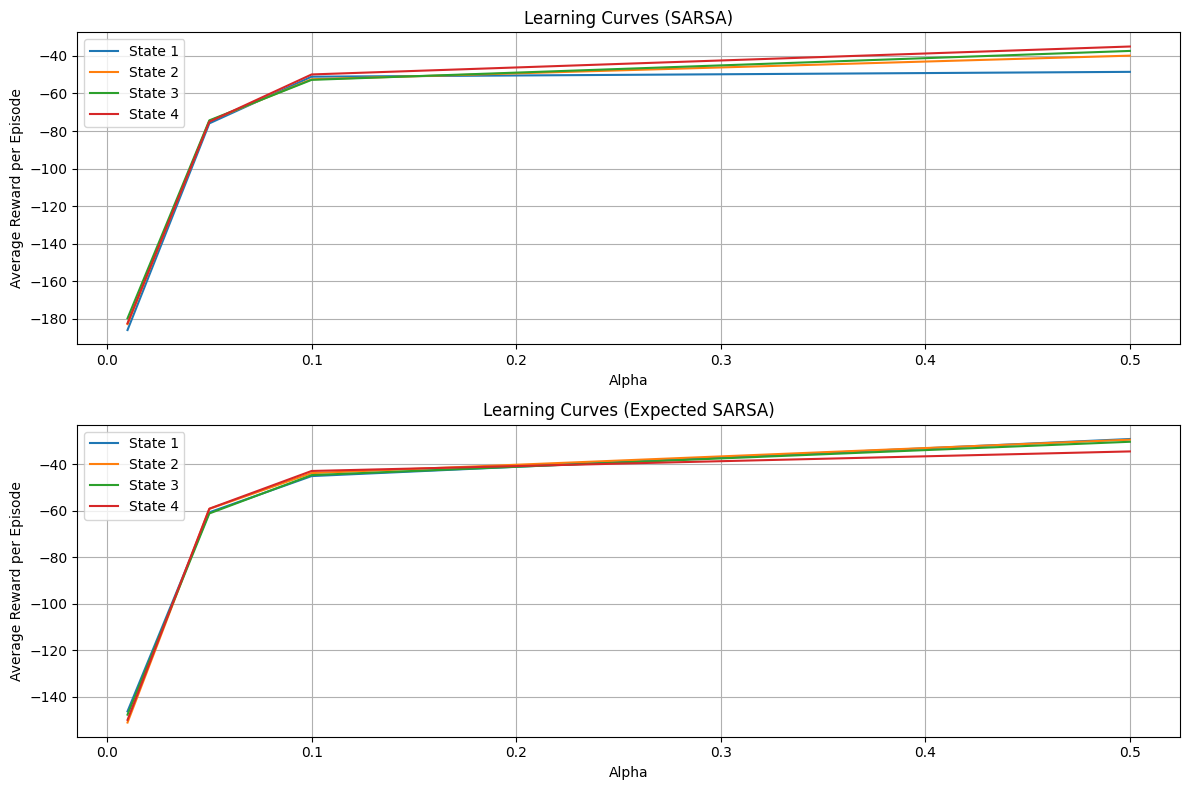

In [ ]:
#Q5

def sarsa(env, num_episodes, alpha, epsilon):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    epR = []
    for episode in range(num_episodes):
        Q = env.reset()
        A = epsilon_greedy_policy(Qtable, Q, epsilon)
        stat = False
        totR = 0
        while  stat==False:
            nextQ, R, stat, _ = env.step(A)
            nextA = epsilon_greedy_policy(Qtable, nextQ, epsilon)
            Qtable[Q, A] += alpha * (R + Qtable[nextQ, nextA] - Qtable[Q, A])
            Q = nextQ
            A = nextA
            totR += R
        epR.append(totR)
    return Qtable, epR

def expected_sarsa(env, num_episodes, alpha, epsilon):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    epR = []

    for episode in range(num_episodes):
        Q = env.reset()
        stat = False
        totR = 0
        while  stat==False:
            action = epsilon_greedy_policy(Qtable, Q, epsilon)
            nextQ, R, stat, _ = env.step(action)
            expected_next_value = np.mean(Qtable[nextQ])
            Qtable[Q, action] += alpha * (R + expected_next_value - Qtable[Q, action])
            Q = nextQ
            totR += R
        epR.append(totR)
    return Qtable, epR

def epsilon_greedy_policy(Qtable, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Qtable[state]))
    else:
        return np.argmax(Qtable[state])

def PlotSnES(alphas, AvgSarsa, AvgESarsa):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    for i, rewards in enumerate([AvgSarsa, AvgESarsa]):
        for j, state_rewards in enumerate(rewards):
            axs[i].plot(alphas, state_rewards, label=f'State {j+1}')
        axs[i].set_xlabel('Alpha')
        axs[i].set_ylabel('Average Reward per Episode')
        axs[i].set_title('Learning Curves' + (' (SARSA)' if i == 0 else ' (Expected SARSA)'))
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

def main():
    env = gym.make("CliffWalking-v0")
    ep_count = 500
    alphas = [0.01, 0.05, 0.1, 0.5]
    AvgSarsa = [[] for _ in range(4)]
    AvgESarsa = [[] for _ in range(4)]

    for alpha in alphas:
        for state in range(4):
            _, rewards = sarsa(env, ep_count, alpha, 0.1)
            AvgSarsa[state].append(np.mean(rewards))
            _, rewards = expected_sarsa(env, ep_count, alpha, 0.1)
            AvgESarsa[state].append(np.mean(rewards))

    PlotSnES(alphas, AvgSarsa, AvgESarsa)

if __name__ == "__main__":
    main()


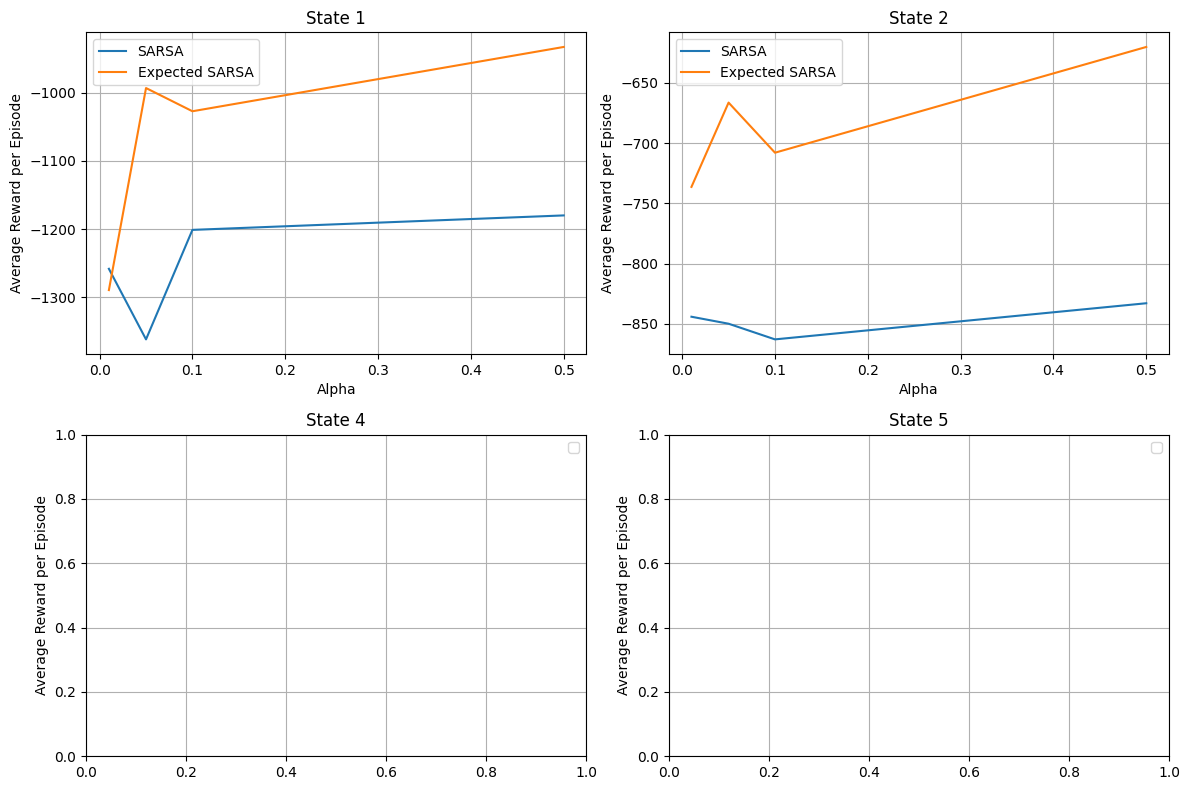

IndexError: list index out of range

In [ ]:
def Plot(alphas, epsilons, AvgSarsa, AvgESarsa):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    for i in range(2):
        for j in range(2):
            if i == 0:
                axs[i, j].plot(alphas, AvgSarsa[j], label='SARSA')
                axs[i, j].plot(alphas, AvgESarsa[j], label='Expected SARSA')
                axs[i, j].set_xlabel('Alpha')
            elif j==5:
                axs[i, j].plot(epsilons, AvgSarsa[j], label='SARSA')
                axs[i, j].plot(epsilons, AvgESarsa[j], label='Expected SARSA')
                axs[i, j].set_xlabel('Epsilon')
            axs[i, j].set_ylabel('Average Reward per Episode')
            axs[i, j].set_title(f'State {j+1 if i == 0 else j+4}')
            axs[i, j].legend()
            axs[i, j].grid(True)
    plt.tight_layout()
    plt.show()

def main():
    env = gym.make("CliffWalking-v0")
    ep_count = 500
    alphas = [0.01, 0.05, 0.1, 0.5]
    epsilons = [0.1, 0.3, 0.5, 0.7, 0.9]
    AvgSarsa = []
    AvgESarsa = []
    for alpha in alphas:
        QRESarsa = []
        QRSarsa = []

        for state in range(4):
            _, REsarsa = expected_sarsa(env, ep_count, alpha, 0.1)
            _, RSarsa = sarsa(env, ep_count, alpha, 0.1)
            QRESarsa.append(np.mean(REsarsa))
            QRSarsa.append(np.mean(RSarsa))
        AvgSarsa.append(QRSarsa)
        AvgESarsa.append(QRESarsa)

    Plot(alphas, epsilons, AvgSarsa, AvgESarsa)

    SarsaAlpha = np.argmax(np.mean(AvgSarsa, axis=1))
    SarsaEpsilon = np.argmax(np.mean(AvgSarsa, axis=0))
    ESarsaAlpha = np.argmax(np.mean(AvgESarsa, axis=1))
    ESarsaEpsilon = np.argmax(np.mean(AvgESarsa, axis=0))

    _, q_table_sarsa = sarsa(env, ep_count, alphas[SarsaAlpha], epsilons[SarsaEpsilon])
    _, q_table_expected_sarsa = expected_sarsa(env, ep_count, alphas[ESarsaAlpha], epsilons[ESarsaEpsilon])
    render_video(env, q_table_sarsa, 'sarsa_best_combination.mp4')
    render_video(env, q_table_expected_sarsa, 'expected_sarsa_best_combination.mp4')

if __name__ == "__main__":
    main()


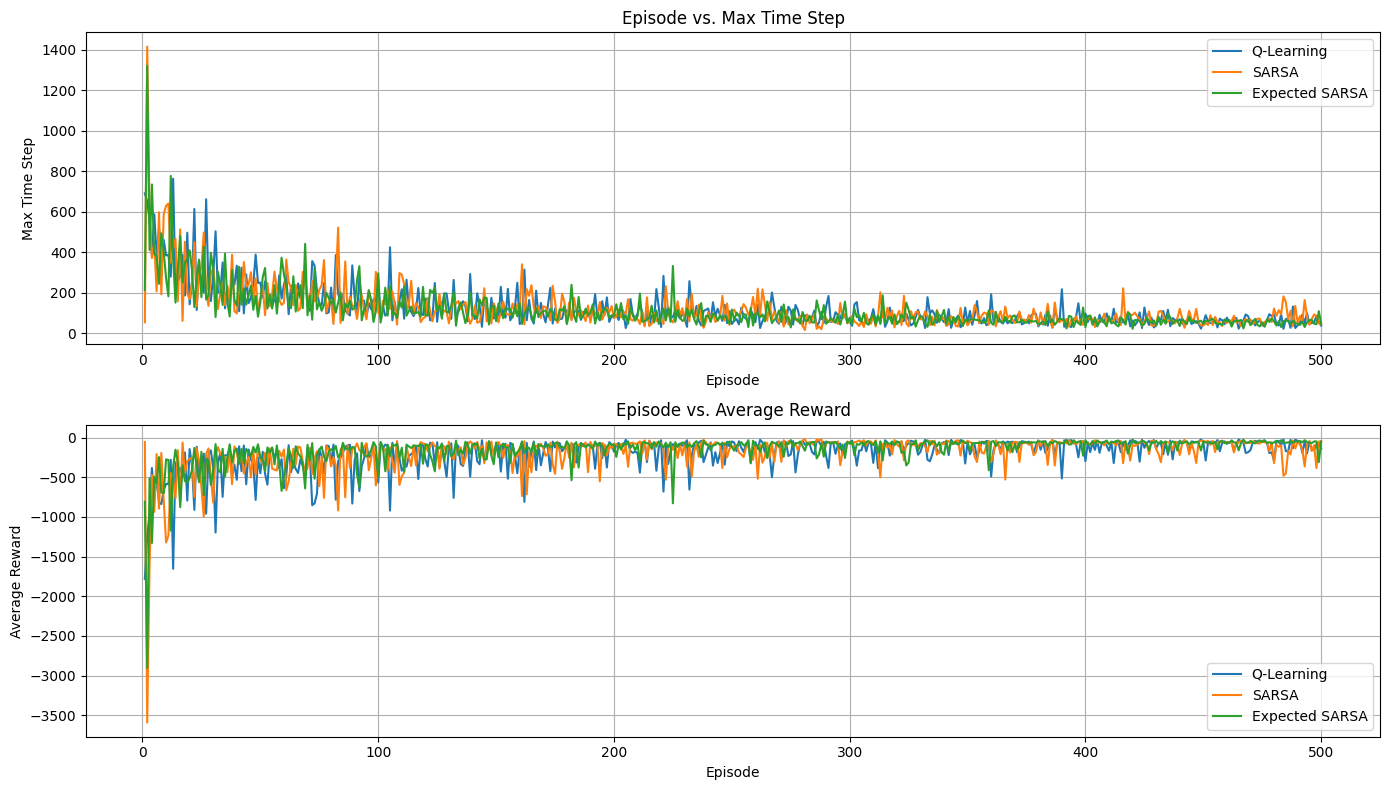

In [ ]:
#Q6
def QL(env, num_episodes, alpha, epsilon, gamma):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    stepEp = []
    epR = []


    for episode in range(num_episodes):
        Q = env.reset()
        done = False
        SumR = 0
        sumStep = 0

        while not done:
            A = epsilon_greedy_policy(Qtable, Q, epsilon)
            next_Q, reward, done, _ = env.step(A)
            Qtable[Q, A] += alpha * (reward + gamma * np.max(Qtable[next_Q]) - Qtable[Q, A])
            Q = next_Q
            SumR += reward
            sumStep += 1
        epR.append(SumR)
        stepEp.append(sumStep)

    return Qtable, epR, stepEp
def sarsa(env, num_episodes, alpha, epsilon, gamma):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    epR = []
    stepEp = []

    for episode in range(num_episodes):
        Q = env.reset()
        A = epsilon_greedy_policy(Qtable, Q, epsilon)
        done = False
        SumR = 0
        sumStep = 0

        while not done:
            next_Q, reward, done, _ = env.step(A)
            next_A = epsilon_greedy_policy(Qtable, next_Q, epsilon)
            Qtable[Q, A] += alpha * (reward + gamma * Qtable[next_Q, next_A] - Qtable[Q, A])
            Q = next_Q
            A = next_A
            SumR += reward
            sumStep += 1
        epR.append(SumR)
        stepEp.append(sumStep)

    return Qtable, epR, stepEp

def expected_sarsa(env, num_episodes, alpha, epsilon, gamma):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    epR = []
    stepEp = []
    for episode in range(num_episodes):
        Q = env.reset()
        done = False
        SumR = 0
        sumStep = 0
        while not done:
            A = epsilon_greedy_policy(Qtable, Q, epsilon)
            next_Q, reward, done, _ = env.step(A)
            expected_next_value = np.mean(Qtable[next_Q])
            Qtable[Q, A] += alpha * (reward + gamma * expected_next_value - Qtable[Q, A])
            Q = next_Q
            SumR += reward
            sumStep += 1
        epR.append(SumR)
        stepEp.append(sumStep)

    return Qtable, epR, stepEp
def epsilon_greedy_policy(Qtable, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Qtable[Q]))
    else:
        return np.argmax(Qtable[Q])
def plot_comparison_graphs(episodes, data_QL, data_sarsa, data_expected_sarsa):
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(episodes, data_QL[2], label='Q-Learning')
    plt.plot(episodes, data_sarsa[2], label='SARSA')
    plt.plot(episodes, data_expected_sarsa[2], label='Expected SARSA')
    plt.xlabel('Episode')
    plt.ylabel('Max Time Step')
    plt.title('Episode vs. Max Time Step')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot(episodes, data_QL[1], label='Q-Learning')
    plt.plot(episodes, data_sarsa[1], label='SARSA')
    plt.plot(episodes, data_expected_sarsa[1], label='Expected SARSA')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Episode vs. Average Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    env = gym.make("CliffWalking-v0")
    num_episodes = 50
    alpha = 0.01
    epsilon = 0.1
    gamma = 0.9
    episodes = np.arange(1, num_episodes + 1)
    Qtable_QL, rewards_QL, steps_QL = QL(env, num_episodes, alpha, epsilon, gamma)
    Qtable_sarsa, rewards_sarsa, steps_sarsa = sarsa(env, num_episodes, alpha, epsilon, gamma)
    Qtable_expected_sarsa, rewards_expected_sarsa, steps_expected_sarsa = expected_sarsa(env, num_episodes, alpha, epsilon, gamma)
    plot_comparison_graphs(episodes, (Qtable_QL, rewards_QL, steps_QL),
                            (Qtable_sarsa, rewards_sarsa, steps_sarsa),
                            (Qtable_expected_sarsa, rewards_expected_sarsa, steps_expected_sarsa))

if __name__ == "__main__":
    main()


In [ ]:
#Q7
import gym
import numpy as np
import matplotlib.pyplot as plt

def sarsa_lambda(env, num_episodes, alpha, epsilon, lmbda):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_policy(state, q_table, epsilon)
        eligibility_trace = np.zeros_like(q_table)
        done = False
        total_reward = 0

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = epsilon_greedy_policy(next_state, q_table, epsilon)
            td_error = reward + np.max(q_table[next_state]) - q_table[state, action]
            eligibility_trace[state, action] += 1
            q_table += alpha * td_error * eligibility_trace
            eligibility_trace *= lmbda

            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode

def epsilon_greedy_policy(state, q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(q_table[state]))
    else:
        return np.argmax(q_table[state])

def train_and_evaluate_sarsa_lambda(env, num_episodes, alpha, epsilon, lmbda):
    q_table, rewards = sarsa_lambda(env, num_episodes, alpha, epsilon, lmbda)
    avg_reward = np.mean(rewards)
    return avg_reward

if __name__ == "__main__":
    env = gym.make("CliffWalking-v0")
    num_episodes = 500
    alpha = 0.0001
    epsilon = 0.17
    lmbda = 0.5

    avg_reward_sarsa_lambda = train_and_evaluate_sarsa_lambda(env, num_episodes, alpha, epsilon, lmbda)
    print("Average reward of SARSA(λ):", avg_reward_sarsa_lambda)


Average reward of SARSA(λ): -616.204
